<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span></li><li><span><a href="#Обучение-модели" data-toc-modified-id="Обучение-модели-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение модели</a></span></li><li><span><a href="#Анализ-обученной-модели" data-toc-modified-id="Анализ-обученной-модели-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ обученной модели</a></span></li><li><span><a href="#Чек-лист" data-toc-modified-id="Чек-лист-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист</a></span></li></ul></div>

# Определение возраста покупателей

## Исследовательский анализ данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
print("Размер выборки:", labels.shape)

Размер выборки: (7591, 2)


Размер выборки выглядит на первый взгляд достаточным для решения задачи, но все зависит от того насколько разнообразны. Если предположить что в выборке, например только улыбающиеся люди, то модель может хуже определять возвраст для людей, которые на фото выглядят грустно или нейтально. Чтобы немного увеличить разнообразие данных применим аугментацию данных. Чтобы предовратить переобучение - из-за нехватки данных применими Dropout.

In [4]:
display(labels.head())
display(labels.tail())
display(labels.info())

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


,file_name,real_age
7586,007608.jpg,14
7587,007609.jpg,37
7588,007610.jpg,28
7589,007611.jpg,20
7590,007612.jpg,47


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


None

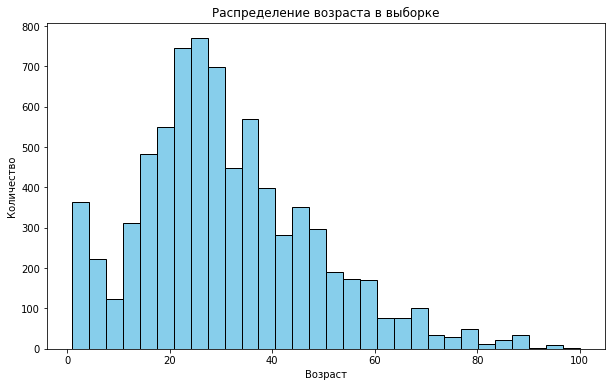

In [5]:
plt.figure(figsize=(10, 6))
plt.hist(labels['real_age'], bins=30, color='skyblue', edgecolor='black')
plt.title('Распределение возраста в выборке')
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.show()

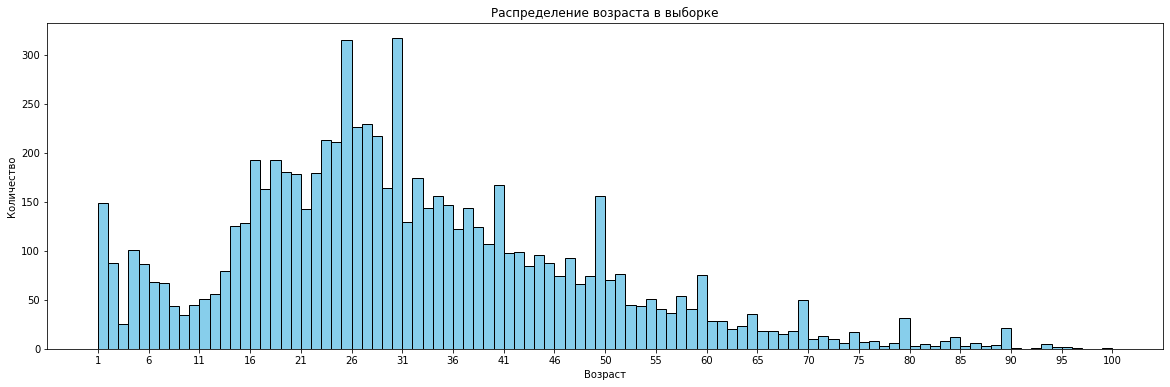

In [6]:
plt.figure(figsize=(20, 6))
counts, bins, patches = plt.hist(labels['real_age'], bins=100, color='skyblue', edgecolor='black')

# Заголовки и подписи осей
plt.title('Распределение возраста в выборке')
plt.xlabel('Возраст')
plt.ylabel('Количество')

# Задаем подписи для каждой корзины
plt.xticks(bins[::5], labels=np.round(bins[::5]).astype(int))  # Подписываем каждую 10-ю корзину

plt.show()

На новом графике явно вырожены два писка на значения 25 и 30 лет - возврасты, которые представлены больше всего.

Found 7591 validated image filenames.


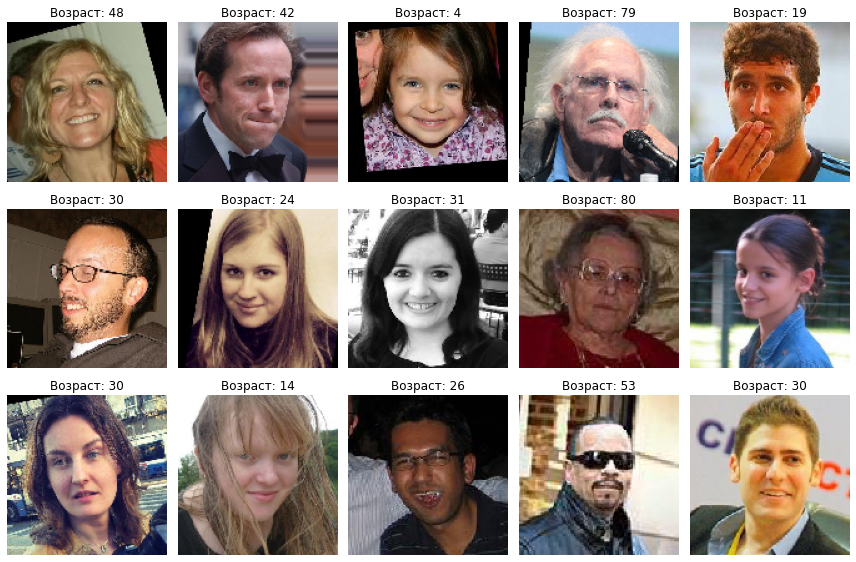

In [7]:
datagen = ImageDataGenerator(rescale=1./255)
generator = datagen.flow_from_dataframe(
    dataframe=labels,
    directory='/datasets/faces/final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(128, 128),
    batch_size=15,
    class_mode='raw'
)

x, y = next(generator) 
fig, axes = plt.subplots(3, 5, figsize=(12, 8))
axes = axes.ravel()
for i in range(15):
    axes[i].imshow(x[i])
    axes[i].set_title(f'Возраст: {y[i]}')
    axes[i].axis('off')
plt.tight_layout()
plt.show()

**Вывод**: Для работы предоставлено 7591 фотография. Распределение имеет два пика в районах 0-3 года и 25 лет. Больше всего данных находится в диапозоне от 20 до 40 лет. Распределение скошено вправо. В выборке имеются и черное белые и цветные фотографии.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

import numpy as np
import pandas as pd
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def load_train(path):
    dataframe = pd.read_csv(f'{path}/labels.csv')
    datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

    train_gen = datagen.flow_from_dataframe(
        dataframe=dataframe,
        directory=f'{path}/final_files',
        x_col="file_name",
        y_col="real_age",
        target_size=(224, 224),
        batch_size=32,
        subset='training',
        class_mode='raw'
    )

    return train_gen

def load_test(path):
    dataframe = pd.read_csv(f'{path}/labels.csv')
    datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

    test_gen = datagen.flow_from_dataframe(
        dataframe=dataframe,
        directory=f'{path}/final_files',
        x_col="file_name",
        y_col="real_age",
        target_size=(224, 224),
        batch_size=32,
        subset='validation',
        class_mode='raw'
    )

    return test_gen


def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False) 
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='linear'))
    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
               steps_per_epoch=None, validation_steps=None):
    model.fit(train_data,
              validation_data=test_data,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2,
              batch_size=batch_size,
              shuffle=True)

    return model

```

```
Epoch 1/10
190/190 - 65s - loss: 226.3303 - mae: 10.8417 - val_loss: 685.6444 - val_mae: 21.2252
Epoch 2/10
190/190 - 38s - loss: 61.4364 - mae: 6.0093 - val_loss: 608.3914 - val_mae: 19.6327
Epoch 3/10
190/190 - 38s - loss: 32.8731 - mae: 4.4459 - val_loss: 281.3390 - val_mae: 12.4330
Epoch 4/10
190/190 - 39s - loss: 21.7882 - mae: 3.6113 - val_loss: 127.3708 - val_mae: 8.3896
Epoch 5/10
190/190 - 39s - loss: 17.4836 - mae: 3.2388 - val_loss: 82.2622 - val_mae: 7.0856
Epoch 6/10
190/190 - 38s - loss: 13.7716 - mae: 2.8906 - val_loss: 67.7607 - val_mae: 6.2312
Epoch 7/10
190/190 - 44s - loss: 10.1510 - mae: 2.4272 - val_loss: 66.1785 - val_mae: 6.1563
Epoch 8/10
190/190 - 53s - loss: 7.9384 - mae: 2.1399 - val_loss: 65.5098 - val_mae: 6.1577
Epoch 9/10
190/190 - 56s - loss: 6.8005 - mae: 1.9766 - val_loss: 69.3360 - val_mae: 6.2302
Epoch 10/10
190/190 - 55s - loss: 6.5828 - mae: 1.9653 - val_loss: 67.2420 - val_mae: 6.1178
Test MAE: 6.1178
48/48 - 8s - loss: 67.2420 - mae: 6.1178

```

```python

import numpy as np
import pandas as pd
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def load_train(path):
    dataframe = pd.read_csv(f'{path}/labels.csv')
    datagen = ImageDataGenerator(
        rescale=1./255, 
        validation_split=0.2,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    train_gen = datagen.flow_from_dataframe(
        dataframe=dataframe,
        directory=f'{path}/final_files',
        x_col="file_name",
        y_col="real_age",
        target_size=(224, 224),
        batch_size=32,
        subset='training',
        class_mode='raw'
    )

    return train_gen

def load_test(path):
    dataframe = pd.read_csv(f'{path}/labels.csv')
    datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

    test_gen = datagen.flow_from_dataframe(
        dataframe=dataframe,
        directory=f'{path}/final_files',
        x_col="file_name",
        y_col="real_age",
        target_size=(224, 224),
        batch_size=32,
        subset='validation',
        class_mode='raw'
    )

    return test_gen


def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False) 
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='linear'))
    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
               steps_per_epoch=None, validation_steps=None):
    model.fit(train_data,
              validation_data=test_data,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2,
              batch_size=batch_size,
              shuffle=True)

    return model


```

```
Epoch 1/15
190/190 - 108s - loss: 271.7573 - mae: 11.8748 - val_loss: 1087.9464 - val_mae: 28.3394
Epoch 2/15
190/190 - 100s - loss: 107.2182 - mae: 7.8182 - val_loss: 1043.1894 - val_mae: 27.5931
Epoch 3/15
190/190 - 100s - loss: 89.2504 - mae: 7.2012 - val_loss: 300.0141 - val_mae: 13.0325
Epoch 4/15
190/190 - 99s - loss: 78.1248 - mae: 6.6941 - val_loss: 136.5042 - val_mae: 8.7688
Epoch 5/15
190/190 - 99s - loss: 68.9686 - mae: 6.3026 - val_loss: 93.8408 - val_mae: 7.2245
Epoch 6/15
190/190 - 99s - loss: 62.4223 - mae: 6.0332 - val_loss: 83.0834 - val_mae: 6.7702
Epoch 7/15
190/190 - 100s - loss: 58.5852 - mae: 5.8159 - val_loss: 93.7475 - val_mae: 7.2463
Epoch 8/15
190/190 - 100s - loss: 48.4420 - mae: 5.3622 - val_loss: 69.7202 - val_mae: 6.2510
Epoch 9/15
190/190 - 99s - loss: 46.8540 - mae: 5.2482 - val_loss: 86.0059 - val_mae: 6.7113
Epoch 10/15
190/190 - 100s - loss: 43.8779 - mae: 5.0790 - val_loss: 91.3552 - val_mae: 6.8427
Epoch 11/15
190/190 - 100s - loss: 40.7015 - mae: 4.8477 - val_loss: 87.7419 - val_mae: 6.7933
Epoch 12/15
190/190 - 98s - loss: 39.1219 - mae: 4.7938 - val_loss: 68.9768 - val_mae: 6.1389
Epoch 13/15
190/190 - 96s - loss: 35.4893 - mae: 4.5773 - val_loss: 79.6190 - val_mae: 6.7062
Epoch 14/15
190/190 - 96s - loss: 33.3682 - mae: 4.4484 - val_loss: 76.1533 - val_mae: 6.3980
Epoch 15/15
190/190 - 96s - loss: 31.4963 - mae: 4.2933 - val_loss: 70.7400 - val_mae: 6.0759
48/48 - 8s - loss: 70.7400 - mae: 6.0759
Test MAE: 6.0759
```

## Анализ обученной модели

Для решения задачи была использована сеть ResNet50 с двумя дополнительными слоями. Обучение проводилось на 10 эпохах. На обучающей выборке зачение mae составило 1.9653, а на тестовой 6.1178, что свидетельствует о переобучении модели.